In [70]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e, c, m_p

import seaborn as sns
sns.set_context('notebook', font_scale=1.5,
                rc={'lines.markeredgewidth': 1})
sns.set_style('darkgrid', {
        'axes.linewidth': 2,
        'legend.fancybox': True})

import curve_tools as cv

## Field and voltage functions

In [86]:
def get_zsfp_and_zufp(f):

    phi_stable = 0
    # This does not work as counting will be violated for large accelerations
    zz = np.linspace(phi_stable - 1.1*zmax, phi_stable + 1.1*zmax) 
    # Safer
    zz = np.linspace(phi_stable - 2*zmax, phi_stable + 2*zmax) 
    z0 = np.atleast_1d(cv.zero_crossings(f, zz))[0]
    
    z0odd = z0[1::2]
    z0even = z0[::2]
    
    if len(z0) == 1:
        return z0, z0
    
    if eta*dp > 0:
        z_sfp, z_ufp = z0odd, z0even
    else:
        z_sfp, z_ufp = z0even, z0odd
        
    return z_sfp, z_ufp


def zufp_separatrix(f):

    z_sfp, z_ufp = get_zsfp_and_zufp(f)
    
    if eta*dp > 0:
        return z_ufp[-1]
    else:
        return z_ufp[0]
    

def H0_for_sigma(sigma_z):
    return sigma_z * np.sqrt(e*V*h/(2*np.pi*p0*R**2))


def H0_for_emittance():
    return sigma_z * np.sqrt(e*V*h/(2*np.pi*p0*R**2))

In [87]:
def efield(V, h, dphi, dp=0):
    def f(z):
        return e/(p0*C) * reduce(
            lambda x, y: x+y, [V[i]*np.sin(h[i]*z/R + dphi[i]) for i in xrange(len(V))]) - dp*beta*c/C
    return f

def voltage(V, h, dphi, dp=0, ef=None):
    def vf(z):
        return e/(p0*C) * reduce(
            lambda x, y: x+y, [R/h[i] * V[i]*np.cos(h[i]*z/R + dphi[i]) for i in xrange(len(V))])

    zmax = zufp_separatrix(ef)

    def f(z):
        return vf(z) - vf(zmax) + dp*beta*c/C * (z - zmax)
    return f

def hamiltonian_f(vf):
    def f(z, dp):
        return -1/2*eta*beta*c*dp**2 + vf(z)
    return f

def eqH(vf, Hc):
    def f(z):
        return np.sqrt(( 2./(eta*beta*c) * (vf(z) - Hc)))

    return f

## Plot & play

In [88]:
%matplotlib inline

In [89]:
# Machine
C      = 6911.
R      = C/(2*np.pi)

p0     = 26e9 * e/c
gamma  = (1 + (p0/(m_p*c))**2)

alpha  = 1/18**2
eta    = alpha - 1/gamma**2
V      = [4e6, -0e6]
h      = [4620, 18480]
dphi   = [0, 0]

# Acceleration
beta          = np.sqrt(1-1/gamma**2)
T0            = C/(beta*c)
normalisation = 1/C * e/p0 * T0
dp            = -0e6 * normalisation

In [90]:
zmax   = C/min(h)/2.
zz = np.linspace(-1.2*zmax, 1.2*zmax, 1000)
pp = np.linspace(-5e-3, 5e-3, 1000)
ZZ, PP = np.meshgrid(zz, pp)

ef = efield(V, h, dphi, dp)
vf = voltage(V, h, dphi, dp, ef)
hamiltonian = hamiltonian_f(vf)
hh = hamiltonian(ZZ, PP)
hc = eqH(vf, 0)

zsfp, zufp = get_zsfp_and_zufp(ef)
z0 = np.array([z for z in zsfp] + [z for z in zufp])

In [91]:
hh

array([[-14.43399214, -14.44100402, -14.44794227, ..., -14.44794227,
        -14.44100402, -14.43399214],
       [-14.38775332, -14.39476519, -14.40170344, ..., -14.40170344,
        -14.39476519, -14.38775332],
       [-14.34160715, -14.34861902, -14.35555728, ..., -14.35555728,
        -14.34861902, -14.34160715],
       ..., 
       [-14.34160715, -14.34861902, -14.35555728, ..., -14.35555728,
        -14.34861902, -14.34160715],
       [-14.38775332, -14.39476519, -14.40170344, ..., -14.40170344,
        -14.39476519, -14.38775332],
       [-14.43399214, -14.44100402, -14.44794227, ..., -14.44794227,
        -14.44100402, -14.43399214]])

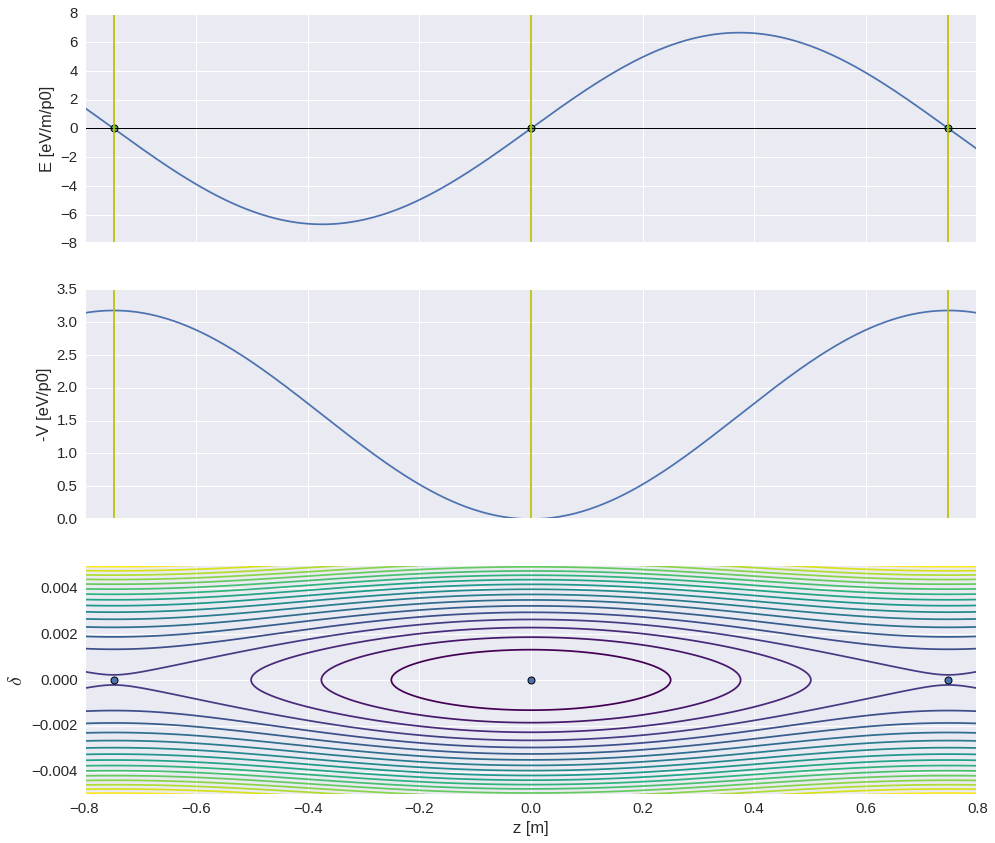

In [92]:
fig1, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,14), sharex=True)

ax1.plot(zz, ef(zz))
ax1.plot(z0, 0*z0, 'o')
ax1.axhline(0, c='k', lw=1)
[ax1.axvline(z, c='y') for z in z0]
ax1.set_ylabel('E [eV/m/p0]')

ax2.plot(zz, -vf(zz))
ax2.axhline(0, c='k', lw=1)
[ax2.axvline(z, c='y') for z in z0]
ax2.set_ylabel('-V [eV/p0]')

ax3.plot(z0, 0*z0, 'o')
ax3.contour(ZZ, PP, hh, levels=[0], colors='orange')
ax3.contour(ZZ, PP, hh, 20, cmap=plt.cm.viridis_r)
ax3.set_xlabel('z [m]')
ax3.set_ylabel('$\delta$', fontsize=20)
ax3.set_xlim(-0.8, 0.8)

plt.show()
# plt.close('all')

# [ax.axhline(0, c='r', ls='--', lw=2) for ax in [ax1, ax2]]
# [ax.axvline(p, c=cl, ls='--', lw=2) for p, cl in zip(ap, ac) for ax in [ax1, ax2]]
# [ax1.plot(p, Es(p), '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
# [ax2.plot(p, -Vs(p), '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
# [ax3.plot(p, 0, '*', c=cl, ms=8) for p, cl in zip(ap, ac)]
# # [ax3.annotate(t, (p,0), (-40, -70), textcoords='offset points', color=cl, fontsize=22,
# #               bbox=dict(boxstyle="round", fc="1"),
# #               arrowprops=dict(arrowstyle="fancy",
# #                               fc="0.6", ec="none",
# #                               connectionstyle="angle3,angleA=0,angleB=-90")) for t, p, cl in zip(at, ap, ac)]
# ax3.plot(ap[1], hc(ap[1]), 'x', c='r', ms=8, mew=2)

In [78]:
def psi_f(H, H0):
    def f(x, y):
        return np.exp(H(x, y).clip(min=0)/H0)
        
    return f

In [49]:
psi = psi_f(hamiltonian, 1e3)
ff = psi(ZZ, PP)

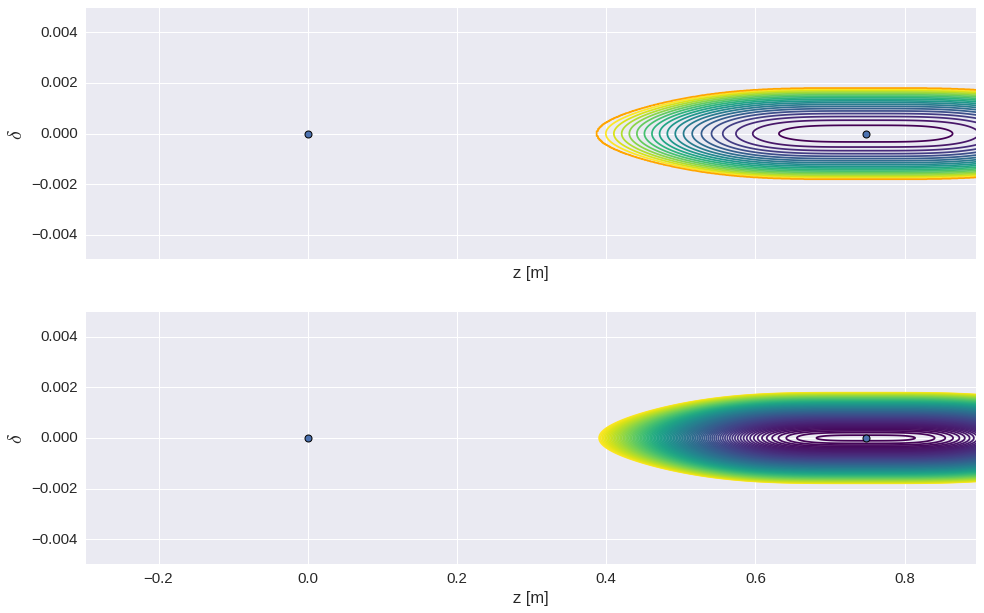

In [50]:
fig1, (ax1, ax2) = plt.subplots(2, figsize=(16,10), sharex=True)

ax1.plot(z0, 0*z0, 'o')
ax1.contour(ZZ, PP, hh.clip(min=0), 20, cmap=plt.cm.viridis_r)
ax1.contour(ZZ, PP, hh.clip(min=0), levels=[0], colors='orange')
ax1.set_xlabel('z [m]')
ax1.set_ylabel('$\delta$', fontsize=20)

ax2.plot(z0, 0*z0, 'o')
ax2.contour(ZZ, PP, ff, 100, cmap=plt.cm.viridis_r)
ax2.contour(ZZ, PP, ff, levels=[0], colors='orange')
ax2.set_xlabel('z [m]')
ax2.set_ylabel('$\delta$', fontsize=20)
ax2.set_xlim(-0.4*zmax, 1.2*zmax)

plt.show()